In [1]:
# Number of Autopilot candidates to evaluate and run batch transform jobs.
# Make sure that you do not put a larger TOP_N_CANDIDATES than the Batch Transform limit for ml.m5.xlarge instances in your account.
TOP_N_CANDIDATES = 5

# Top Candidates Customer Churn Prediction with Amazon SageMaker Autopilot and Batch Transform (Python SDK)
_**Using AutoPilot to Predict Mobile Customer Departure and Custom Evaluations with the Python SDK**_

---

---

This notebook works with sagemaker python sdk 2.x

## Contents

1. [Introduction](#Introduction)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Train](#Settingup)
1. [Autopilot Results](#Results)
1. [Evaluate Top Candidates](#Evaluation)
1. [Cleanup](#Cleanup)


---

## Introduction

Amazon SageMaker Autopilot is an automated machine learning (commonly referred to as AutoML) solution for tabular datasets. You can use SageMaker Autopilot in different ways: on autopilot (hence the name) or with human guidance, without code through SageMaker Studio, or using the AWS SDKs. This notebook, as a first glimpse, will use the AWS SDKs to simply create and deploy a machine learning model.

With the new feature released on 6/19/2020 (sagemaker python sdk >= 1.65.1), Autopilot generated models can be configured to return probabilities of each inference. This will enable data scientists to further analyze the performance of the model with additional metrics and to choose an appropriate threshold as operating point. This notebook demonstrate how to configure the model to obtain the inference probability (see [Customize the Inference Response](#Customize-the-Inference-Response)), select top N models, and make Batch Transform on a hold-out test set for evaluation. Note that this feature only works with Autopilot models created after the release of the new feature, i.e. after 6/19/2020, you will have to rerun Autopilot jobs to recreate the models in order to obtain the probability score during inference.

Losing customers is costly for any business.  Identifying unhappy customers early on gives you a chance to offer them incentives to stay.  This notebook describes using machine learning (ML) for the automated identification of unhappy customers, also known as customer churn prediction. ML models rarely give perfect predictions though, so this notebook is also about how to incorporate the relative costs of prediction mistakes when determining the financial outcome of using ML.

We use an example of churn that is familiar to all of us–leaving a mobile phone operator.  Seems like I can always find fault with my provider du jour! And if my provider knows that I’m thinking of leaving, it can offer timely incentives–I can always use a phone upgrade or perhaps have a new feature activated–and I might just stick around. Incentives are often much more cost effective than losing and reacquiring a customer.

In this notebook, we use the high-level [SageMaker Python SDK](https://github.com/aws/sagemaker-python-sdk). There's also [another example notebook](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/autopilot/autopilot_customer_churn.ipynb) with the same Customer Churn dataset that uses the [low-level Boto3 SDK](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker.html)

---
## Setup

_This notebook was created and tested on an ml.t3.medium notebook instance._

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).
- The number of top candidates (`TOP_N_CANDIDATES`) to explore and compare with different metrics  (AUC, Precision-recall and ROC) on the heldout data split. We demonstrate how to compute these metrics for each candidate by running transform jobs. (Note that `TOP_N_CANDIDATES` was defined in the first cell of this notebook). 

In [2]:
# to get the latest sagemaker python sdk
!pip install -U sagemaker

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 440 kB 42.0 MB/s eta 0:00:01
  Created wheel for sagemaker: filename=sagemaker-2.59.1-py2.py3-none-any.whl size=616405 sha256=d89d9809e8f09a5fc390417afd3a5f06a051655067245946468e134177227712
  Stored in directory: /root/.cache/pip/wheels/66/1d/e5/1fa39de6ea80e632091180726d717ba5b3539f39d44add7a95
Successfully built sagemaker
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.58.0
    Uninstalling sagemaker-2.58.0:
      Successfully uninstalled sagemaker-2.58.0
You should consider upgrading via the '/opt/conda/bin/pyth

In [3]:
import sagemaker
import boto3
from sagemaker import get_execution_role

print(sagemaker.__version__)

region = boto3.Session().region_name

session = sagemaker.Session()

# You can modify the following to use a bucket of your choosing
bucket = session.default_bucket()
prefix = "sagemaker/DEMO-autopilot-churn-SDK"

role = get_execution_role()

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

2.59.1


Next, we'll import the Python libraries we'll need for the remainder of the exercise.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sagemaker import AutoML
from time import gmtime, strftime, sleep
from pprint import pprint
import json
import io
from urllib.parse import urlparse
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    classification_report,
    average_precision_score,
    precision_score,
    recall_score,
)
import matplotlib.pyplot as plt

---
## Data

Mobile operators have historical records on which customers ultimately ended up churning and which continued using the service. We can use this historical information to construct an ML model of one mobile operator’s churn using a process called training. After training the model, we can pass the profile information of an arbitrary customer (the same profile information that we used to train the model) to the model, and have the model predict whether this customer is going to churn. Of course, we expect the model to make mistakes–after all, predicting the future is tricky business! But I’ll also show how to deal with prediction errors.

The dataset we will use is synthetically generated, but indictive of the types of features you'd see in this use case.

In [5]:
!aws s3 cp s3://sagemaker-sample-files/datasets/tabular/synthetic/churn.txt ./

download: s3://sagemaker-sample-files/datasets/tabular/synthetic/churn.txt to ./churn.txt


### Inspect your Dataset

Before you run Autopilot on the dataset, first perform a check of the dataset to make sure that it has no obvious errors. The Autopilot process can take long time, and it's generally a good practice to inspect the dataset before you start a job. This particular dataset is small, so you can inspect it in the notebook instance itself. If you have a larger dataset that will not fit in a notebook instance memory, inspect the dataset offline using a big data analytics tool like Apache Spark. [Deequ](https://github.com/awslabs/deequ) is a library built on top of Apache Spark that can be helpful for performing checks on large datasets. Autopilot is capable of handling datasets up to 5 GB.

Read the data into a Pandas data frame and take a look.

In [6]:
churn = pd.read_csv("./churn.txt")
pd.set_option("display.max_columns", 500)
churn

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,PA,163,806,403-2562,no,yes,300,8.162204,3,7.579174,3.933035,4,6.508639,4.065759,100,5.111624,4.928160,6,5.673203,3,True.
1,SC,15,836,158-8416,yes,no,0,10.018993,4,4.226289,2.325005,0,9.972592,7.141040,200,6.436188,3.221748,6,2.559749,8,False.
2,MO,131,777,896-6253,no,yes,300,4.708490,3,4.768160,4.537466,3,4.566715,5.363235,100,5.142451,7.139023,2,6.254157,4,False.
3,WY,75,878,817-5729,yes,yes,700,1.268734,3,2.567642,2.528748,5,2.333624,3.773586,450,3.814413,2.245779,6,1.080692,6,False.
4,WY,146,878,450-4942,yes,no,0,2.696177,3,5.908916,6.015337,3,3.670408,3.751673,250,2.796812,6.905545,4,7.134343,6,True.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,NH,4,787,151-3162,yes,yes,800,10.862632,5,7.250969,6.936164,1,8.026482,4.921314,350,6.748489,4.872570,8,2.122530,9,False.
4996,SD,140,836,351-5993,no,no,0,1.581127,8,3.758307,7.377591,7,1.328827,0.939932,300,4.522661,6.938571,2,4.600473,4,False.
4997,SC,32,836,370-3127,no,yes,700,0.163836,5,4.243980,5.841852,3,2.340554,0.939469,450,5.157898,4.388328,7,1.060340,6,False.
4998,MA,142,776,604-2108,yes,yes,600,2.034454,5,3.014859,4.140554,3,3.470372,6.076043,150,4.362780,7.173376,3,4.871900,7,True.


By modern standards, it’s a relatively small dataset, with only 5,000 records, where each record uses 21 attributes to describe the profile of a customer of an unknown US mobile operator. The attributes are:

- `State`: the US state in which the customer resides, indicated by a two-letter abbreviation; for example, OH or NJ
- `Account Length`: the number of days that this account has been active
- `Area Code`: the three-digit area code of the corresponding customer’s phone number
- `Phone`: the remaining seven-digit phone number
- `Int’l Plan`: whether the customer has an international calling plan: yes/no
- `VMail Plan`: whether the customer has a voice mail feature: yes/no
- `VMail Message`: presumably the average number of voice mail messages per month
- `Day Mins`: the total number of calling minutes used during the day
- `Day Calls`: the total number of calls placed during the day
- `Day Charge`: the billed cost of daytime calls
- `Eve Mins, Eve Calls, Eve Charge`: the billed cost for calls placed during the evening
- `Night Mins`, `Night Calls`, `Night Charge`: the billed cost for calls placed during nighttime
- `Intl Mins`, `Intl Calls`, `Intl Charge`: the billed cost for international calls
- `CustServ Calls`: the number of calls placed to Customer Service
- `Churn?`: whether the customer left the service: true/false

The last attribute, `Churn?`, is known as the target attribute–the attribute that we want the ML model to predict.

### Reserve some data for calling inference on the model

Divide the data into training and testing splits. The training split is used by SageMaker Autopilot. The testing split is reserved to perform inference using the suggested model.

In [7]:
train_data = churn.sample(frac=0.8, random_state=200)

test_data = churn.drop(train_data.index)

test_data_no_target = test_data.drop(columns=["Churn?"])

Let's save these train and test data splits to csv files locally

In [8]:
train_file = "train_data.csv"
train_data.to_csv(train_file, index=False, header=True)

test_file = "test_data.csv"
test_data_no_target.to_csv(test_file, index=False, header=False)

## Setting up the SageMaker Autopilot Job<a name="Settingup"></a>

We will use the `AutoML` estimator from SageMaker Python SDK to invoke Autopilot to find the best ML pipeline to train a model on this dataset. 

The required inputs for invoking a Autopilot job are:
* local or s3 location for input dataset (if local, the dataset will be uploaded to s3)
* Name of the column of the dataset you want to predict (`Churn?` in this case) 
* An IAM role

Currently Autopilot supports only tabular datasets in CSV format. Either all files should have a header row, or the first file of the dataset, when sorted in alphabetical/lexical order by name, is expected to have a header row.

In [9]:
from sagemaker import AutoML
from time import gmtime, strftime, sleep

timestamp_suffix = strftime("%d-%H-%M-%S", gmtime())
base_job_name = "automl-churn-sdk-" + timestamp_suffix

target_attribute_name = "Churn?"
target_attribute_values = np.unique(train_data[target_attribute_name])
target_attribute_true_value = target_attribute_values[1]  # 'True.'

automl = AutoML(
    role=role,
    target_attribute_name=target_attribute_name,
    base_job_name=base_job_name,
    sagemaker_session=session,
    max_candidates=20,
)

You can also specify the type of problem you want to solve with your dataset (`Regression, MulticlassClassification, BinaryClassification`) with the `problem_type` keywork argument. In case you are not sure, SageMaker Autopilot will infer the problem type based on statistics of the target column (the column you want to predict). 

Because the target attribute, ```Churn?```, is binary, our model will be performing binary prediction, also known as binary classification. In this example we will let AutoPilot infer the type of problem for us.

You have the option to limit the running time of a SageMaker Autopilot job by providing either the maximum number of pipeline evaluations or candidates (one pipeline evaluation is called a `Candidate` because it generates a candidate model) or providing the total time allocated for the overall Autopilot job. Under default settings, this job takes about four hours to run. This varies between runs because of the nature of the exploratory process Autopilot uses to find optimal training parameters.

We limit the number of candidates to 20 so that the job finishes in a few minutes.

### Launching the SageMaker Autopilot Job<a name="Launching"></a>

You can now launch the Autopilot job by calling the `fit` method of the `AutoML` estimator.

In [10]:
automl.fit(train_file, job_name=base_job_name, wait=False, logs=False)

### Tracking SageMaker Autopilot Job Progress<a name="Tracking"></a>
SageMaker Autopilot job consists of the following high-level steps : 
* Analyzing Data, where the dataset is analyzed and Autopilot comes up with a list of ML pipelines that should be tried out on the dataset. The dataset is also split into train and validation sets.
* Feature Engineering, where Autopilot performs feature transformation on individual features of the dataset as well as at an aggregate level.
* Model Tuning, where the top performing pipeline is selected along with the optimal hyperparameters for the training algorithm (the last stage of the pipeline). 

We can use the `describe_auto_ml_job` method to check the status of our SageMaker Autopilot job.

In [ ]:
print("JobStatus - Secondary Status")
print("------------------------------")


describe_response = automl.describe_auto_ml_job()
print(describe_response["AutoMLJobStatus"] + " - " + describe_response["AutoMLJobSecondaryStatus"])
job_run_status = describe_response["AutoMLJobStatus"]

while job_run_status not in ("Failed", "Completed", "Stopped"):
    describe_response = automl.describe_auto_ml_job()
    job_run_status = describe_response["AutoMLJobStatus"]

    print(
        describe_response["AutoMLJobStatus"] + " - " + describe_response["AutoMLJobSecondaryStatus"]
    )
    sleep(30)

JobStatus - Secondary Status
------------------------------
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - Fea

---
## Describing the SageMaker Autopilot Job Results <a name="Results"></a>

We can use the `describe_auto_ml_job` method to look up the best candidate generated by the SageMaker Autopilot job. This notebook demonstrate end-to-end Autopilot so that we have a already initialized `automl` object. 

**Note: Using Another Autopilot Job**

If you want to retrieve a previous Autopilot job or an Autopilot job launched outside of this notebook, such as from the SageMaker Studio UI, from the CLI, etc, you can use the following lines to prior to the next cell. If you are using a different dataset, you must also override the following variables defined in the [Data](#Data) section in order to run the batch jobs and perform the analysis: `test_data`, `test_data_no_target`, `test_file`, `target_attribute_name`, `target_attribute_values`, and `target_attribute_true_value`.

```python
from sagemaker import AutoML
automl = AutoML.attach(auto_ml_job_name='<autopilot-job-name>')

test_data = ... # test_data to be used (with target column)
test_data_no_target = ... # test_data to be used (without target column)
test_file = ... # path of data to upload to S3 and perform batch inference (csv file of test_data_no_target)
target_attribute_name = ... # name of target column (values to predict)
target_attribute_values = ... # list of unique values in target column (sorted)
target_attribute_true_value = ... # second value in target column (binary classification "True" class)

```

In [12]:
best_candidate = automl.describe_auto_ml_job()["BestCandidate"]
best_candidate_name = best_candidate["CandidateName"]
pprint(best_candidate)
print("\n")
print("CandidateName: " + best_candidate_name)
print(
    "FinalAutoMLJobObjectiveMetricName: "
    + best_candidate["FinalAutoMLJobObjectiveMetric"]["MetricName"]
)
print(
    "FinalAutoMLJobObjectiveMetricValue: "
    + str(best_candidate["FinalAutoMLJobObjectiveMetric"]["Value"])
)

{'CandidateName': 'automl-churn-sdk-03-20-05-01cpZw-009-919c9ea9',
 'CandidateProperties': {'CandidateArtifactLocations': {'Explainability': 's3://sagemaker-us-east-1-503254810580/automl-churn-sdk-03-20-05-01/documentation/explainability/output'}},
 'CandidateStatus': 'Completed',
 'CandidateSteps': [{'CandidateStepArn': 'arn:aws:sagemaker:us-east-1:503254810580:processing-job/automl-churn-sdk-03-20-05-01-db-1-05f30264d04f4669858b1c92e8339',
                     'CandidateStepName': 'automl-churn-sdk-03-20-05-01-db-1-05f30264d04f4669858b1c92e8339',
                     'CandidateStepType': 'AWS::SageMaker::ProcessingJob'},
                    {'CandidateStepArn': 'arn:aws:sagemaker:us-east-1:503254810580:training-job/automl-churn-sdk-03-20-05-01-dpp9-1-7eef44401bda49c29da87c79f3b',
                     'CandidateStepName': 'automl-churn-sdk-03-20-05-01-dpp9-1-7eef44401bda49c29da87c79f3b',
                     'CandidateStepType': 'AWS::SageMaker::TrainingJob'},
                    {'Ca

Due to some randomness in the algorithms involved, different runs will provide slightly different results, but accuracy will be around or above $93\%$, which is a good result.

### Check Top Candidates

In addition to the `best_candidate`, we can also explore the other top candidates generated by SageMaker Autopilot. 

We use the `list_candidates` method to see our other top candidates.

In [13]:
TOP_N_CANDIDATES  # number of top candidates to check, defined at the beginning of the notebook

5

In [14]:
candidates = automl.list_candidates(
    sort_by="FinalObjectiveMetricValue", sort_order="Descending", max_results=TOP_N_CANDIDATES
)

for candidate in candidates:
    print("Candidate name: ", candidate["CandidateName"])
    print("Objective metric name: ", candidate["FinalAutoMLJobObjectiveMetric"]["MetricName"])
    print("Objective metric value: ", candidate["FinalAutoMLJobObjectiveMetric"]["Value"])
    print("\n")

Candidate name:  automl-churn-sdk-03-20-05-01cpZw-009-919c9ea9
Objective metric name:  validation:binary_f_beta
Objective metric value:  0.9469895362854004


Candidate name:  automl-churn-sdk-03-20-05-01cpZw-005-ba7401ea
Objective metric name:  validation:f1_binary
Objective metric value:  0.9381499886512756


Candidate name:  automl-churn-sdk-03-20-05-01cpZw-004-64ef8543
Objective metric name:  validation:f1_binary
Objective metric value:  0.9374899864196777


Candidate name:  automl-churn-sdk-03-20-05-01cpZw-010-c7dcc7ed
Objective metric name:  validation:binary_f_beta
Objective metric value:  0.9374728202819824


Candidate name:  automl-churn-sdk-03-20-05-01cpZw-007-d7163c67
Objective metric name:  validation:f1_binary
Objective metric value:  0.9358100295066833




---
## Evaluate Top Candidates <a name="Evaluation"></a>

Once our SageMaker Autopilot job has finished, we can start running inference on the top candidates. In SageMaker, you can perform inference in two ways: online endpoint inference or batch transform inference. Lets focus on batch transform inference.

We'll perform batch transform on our top candidates and analyze some custom metrics from our top candidates' prediction results.

### Upload Data for Transform Jobs

We'll use the `test_data` which we defined when we split out data in train and test splits. We need to upload this data to S3. As a refresher, here's `test_data`

In [15]:
test_data.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
2,MO,131,777,896-6253,no,yes,300,4.708490,3,4.768160,4.537466,3,4.566715,5.363235,100,5.142451,7.139023,2,6.254157,4,False.
17,NY,142,788,248-9207,yes,no,0,0.631607,4,0.817364,4.399598,0,2.024482,3.156505,200,6.124743,5.644293,3,1.532017,10,True.
18,NJ,111,787,843-5355,yes,yes,700,11.615619,2,7.898472,9.791104,0,7.375764,5.144235,250,6.855468,4.413320,4,8.499380,6,False.
37,WV,4,878,510-9652,no,yes,500,4.677963,6,6.259296,5.786310,7,3.780335,3.309557,450,6.299289,3.450221,7,0.853121,7,False.
39,OK,14,797,437-5663,yes,yes,600,4.372232,3,4.763078,5.350116,4,4.920831,6.597559,350,3.057663,5.956779,6,5.478657,5,False.


In [16]:
input_data_transform = session.upload_data(path=test_file, bucket=bucket, key_prefix=prefix)
print("Uploaded transform data to {}".format(input_data_transform))

Uploaded transform data to s3://sagemaker-us-east-1-503254810580/sagemaker/DEMO-autopilot-churn-SDK/test_data.csv


### Customize the Inference Response

For classification problem types, the inference containers generated by SageMaker Autopilot allow you to select the response content for predictions. Valid inference response content are defined below for binary classification and multiclass classification problem types.

- `'predicted_label'` - predicted class
- `'probability'` - In binary classification, the probability that the result is predicted as the second or `True` class in the target column. In multiclass classification, the probability of the winning class.
- `'labels'` - list of all possible classes
- `'probabilities'` - list of all probabilities for all classes (order corresponds with `'labels'`)

By default the inference contianers are configured to generate the `'predicted_label'`.

In this example we use `‘predicted_label’` and `‘probability’` to demonstrate how to evaluate the models with custom metrics. For the Churn dataset, the second or `True` class is the string`'True.'`


In [17]:
inference_response_keys = ["predicted_label", "probability"]

### Create the Models and Tranform Estimators

Let's create our Models and Batch Transform Estimators using the `create_model` method. We can specify our inference response using the `inference_response_keys` keyword argument.

In [18]:
s3_transform_output_path = "s3://{}/{}/inference-results/".format(bucket, prefix)

transformers = []

for candidate in candidates:
    model = automl.create_model(
        name=candidate["CandidateName"],
        candidate=candidate,
        inference_response_keys=inference_response_keys,
    )

    output_path = s3_transform_output_path + candidate["CandidateName"] + "/"

    transformers.append(
        model.transformer(
            instance_count=1,
            instance_type="ml.m5.xlarge",
            assemble_with="Line",
            output_path=output_path,
        )
    )

print("Setting up {} Batch Transform Jobs in `transformers`".format(len(transformers)))

Setting up 5 Batch Transform Jobs in `transformers`


### Start the Transform Jobs

Let's start all the transform jobs.

In [19]:
for transformer in transformers:
    transformer.transform(
        data=input_data_transform, split_type="Line", content_type="text/csv", wait=False
    )
    print("Starting transform job {}".format(transformer._current_job_name))

Starting transform job automl-churn-sdk-03-20-05-01cpZw-009-91-2021-09-03-21-52-33-809
Starting transform job automl-churn-sdk-03-20-05-01cpZw-005-ba-2021-09-03-21-52-34-271
Starting transform job automl-churn-sdk-03-20-05-01cpZw-004-64-2021-09-03-21-52-35-032
Starting transform job automl-churn-sdk-03-20-05-01cpZw-010-c7-2021-09-03-21-52-41-625
Starting transform job automl-churn-sdk-03-20-05-01cpZw-007-d7-2021-09-03-21-52-43-071


Now we wait for our transform jobs to finish.

In [20]:
pending_complete = True

while pending_complete:
    pending_complete = False
    num_transform_jobs = len(transformers)
    for transformer in transformers:
        desc = sm.describe_transform_job(TransformJobName=transformer._current_job_name)
        if desc["TransformJobStatus"] not in ["Failed", "Completed"]:
            pending_complete = True
        else:
            num_transform_jobs -= 1
    print("{} out of {} transform jobs are running.".format(num_transform_jobs, len(transformers)))
    sleep(30)

for transformer in transformers:
    desc = sm.describe_transform_job(TransformJobName=transformer._current_job_name)
    print(
        "Transform job '{}' finished with status {}".format(
            transformer._current_job_name, desc["TransformJobStatus"]
        )
    )

5 out of 5 transform jobs are running.
5 out of 5 transform jobs are running.
5 out of 5 transform jobs are running.
5 out of 5 transform jobs are running.
5 out of 5 transform jobs are running.
5 out of 5 transform jobs are running.
5 out of 5 transform jobs are running.
5 out of 5 transform jobs are running.
5 out of 5 transform jobs are running.
5 out of 5 transform jobs are running.
5 out of 5 transform jobs are running.
1 out of 5 transform jobs are running.
0 out of 5 transform jobs are running.
Transform job 'automl-churn-sdk-03-20-05-01cpZw-009-91-2021-09-03-21-52-33-809' finished with status Completed
Transform job 'automl-churn-sdk-03-20-05-01cpZw-005-ba-2021-09-03-21-52-34-271' finished with status Completed
Transform job 'automl-churn-sdk-03-20-05-01cpZw-004-64-2021-09-03-21-52-35-032' finished with status Completed
Transform job 'automl-churn-sdk-03-20-05-01cpZw-010-c7-2021-09-03-21-52-41-625' finished with status Completed
Transform job 'automl-churn-sdk-03-20-05-01cpZw-0

### Evaluate the Inference Results

Now we analyze our inference results. The batch transform results are stored in S3. So we define a helper method to get the results from S3.

In [21]:
import json
import io
from urllib.parse import urlparse


def get_csv_from_s3(s3uri, file_name):
    parsed_url = urlparse(s3uri)
    bucket_name = parsed_url.netloc
    prefix = parsed_url.path[1:].strip("/")
    s3 = boto3.resource("s3")
    obj = s3.Object(bucket_name, "{}/{}".format(prefix, file_name))
    return obj.get()["Body"].read().decode("utf-8")

In [22]:
predictions = []

for transformer in transformers:
    print(transformer.output_path)
    pred_csv = get_csv_from_s3(transformer.output_path, "{}.out".format(test_file))
    predictions.append(pd.read_csv(io.StringIO(pred_csv), header=None))

s3://sagemaker-us-east-1-503254810580/sagemaker/DEMO-autopilot-churn-SDK/inference-results/automl-churn-sdk-03-20-05-01cpZw-009-919c9ea9/
s3://sagemaker-us-east-1-503254810580/sagemaker/DEMO-autopilot-churn-SDK/inference-results/automl-churn-sdk-03-20-05-01cpZw-005-ba7401ea/
s3://sagemaker-us-east-1-503254810580/sagemaker/DEMO-autopilot-churn-SDK/inference-results/automl-churn-sdk-03-20-05-01cpZw-004-64ef8543/
s3://sagemaker-us-east-1-503254810580/sagemaker/DEMO-autopilot-churn-SDK/inference-results/automl-churn-sdk-03-20-05-01cpZw-010-c7dcc7ed/
s3://sagemaker-us-east-1-503254810580/sagemaker/DEMO-autopilot-churn-SDK/inference-results/automl-churn-sdk-03-20-05-01cpZw-007-d7163c67/


We will use the `sklearn.metrics` module to analyze our prediction results.

In [23]:
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    classification_report,
    average_precision_score,
)
import matplotlib.pyplot as plt

labels = test_data[target_attribute_name].apply(
    lambda row: True if row == target_attribute_true_value else False
)

# calculate auc score
for prediction, candidate in zip(predictions, candidates):
    roc_auc = roc_auc_score(labels, prediction.loc[:, 1])
    ap = average_precision_score(labels, prediction.loc[:, 1])
    print(
        "%s's ROC AUC = %.2f, Average Precision = %.2f" % (candidate["CandidateName"], roc_auc, ap)
    )
    print(classification_report(test_data[target_attribute_name], prediction.loc[:, 0]))
    print()

automl-churn-sdk-03-20-05-01cpZw-009-919c9ea9's ROC AUC = 0.99, Average Precision = 0.99
              precision    recall  f1-score   support

      False.       0.97      0.95      0.96       498
       True.       0.95      0.97      0.96       502

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000


automl-churn-sdk-03-20-05-01cpZw-005-ba7401ea's ROC AUC = 0.98, Average Precision = 0.97
              precision    recall  f1-score   support

      False.       0.95      0.91      0.93       498
       True.       0.92      0.95      0.93       502

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000


automl-churn-sdk-03-20-05-01cpZw-004-64ef8543's ROC AUC = 0.98, Average Precision = 0.97
              precision    recall  f1-score   support

      False.       0.9

Plot the ROC curve.

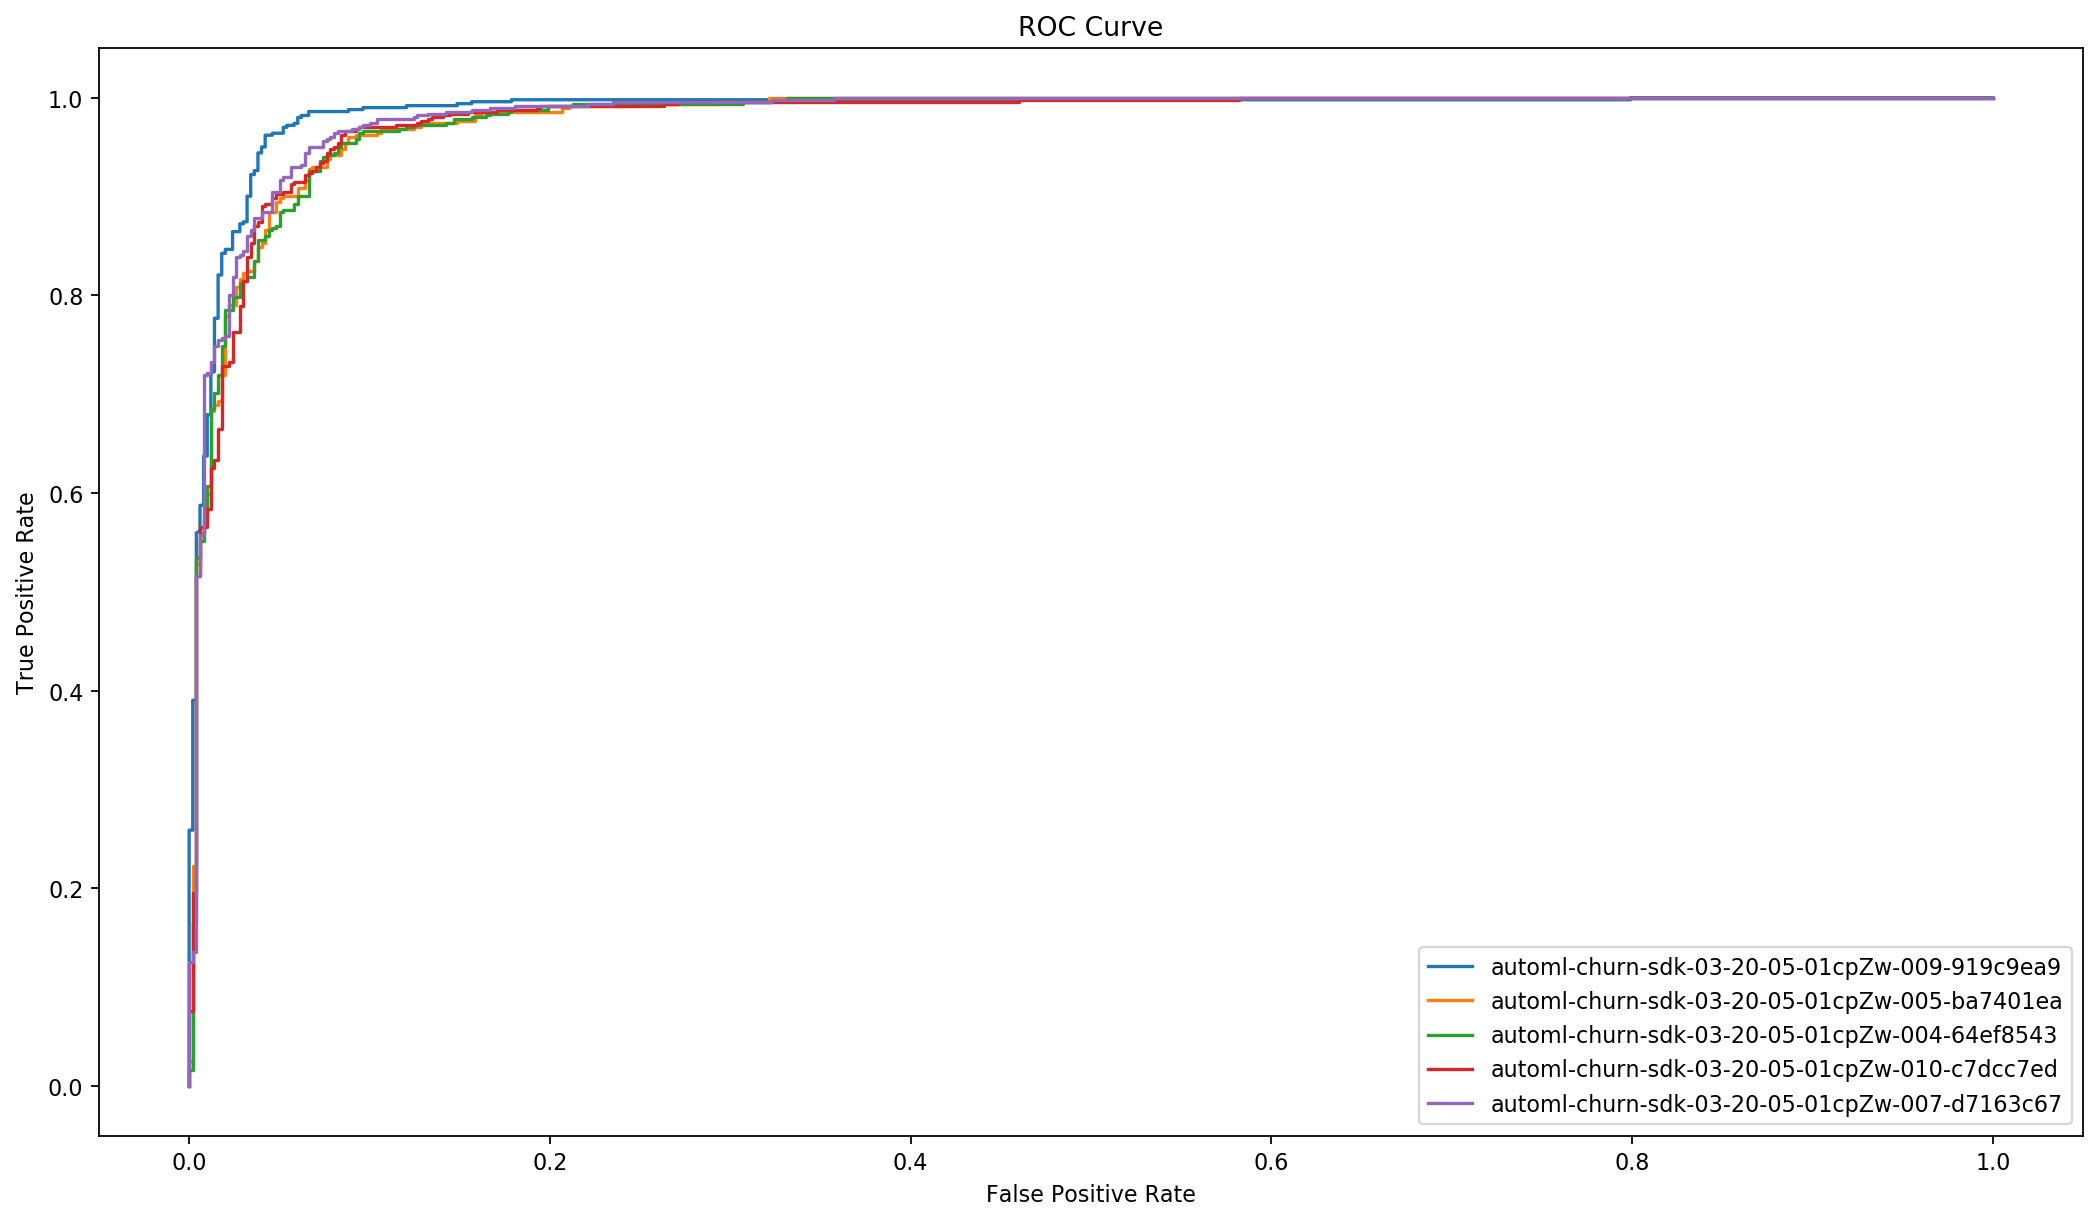

In [24]:
fpr_tpr = []
for prediction in predictions:
    fpr, tpr, _ = roc_curve(labels, prediction.loc[:, 1])
    fpr_tpr.append(fpr)
    fpr_tpr.append(tpr)

plt.figure(num=None, figsize=(16, 9), dpi=160, facecolor="w", edgecolor="k")
plt.plot(*fpr_tpr)
plt.legend([candidate["CandidateName"] for candidate in candidates], loc="lower right")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

Plot the precision-recall curve.

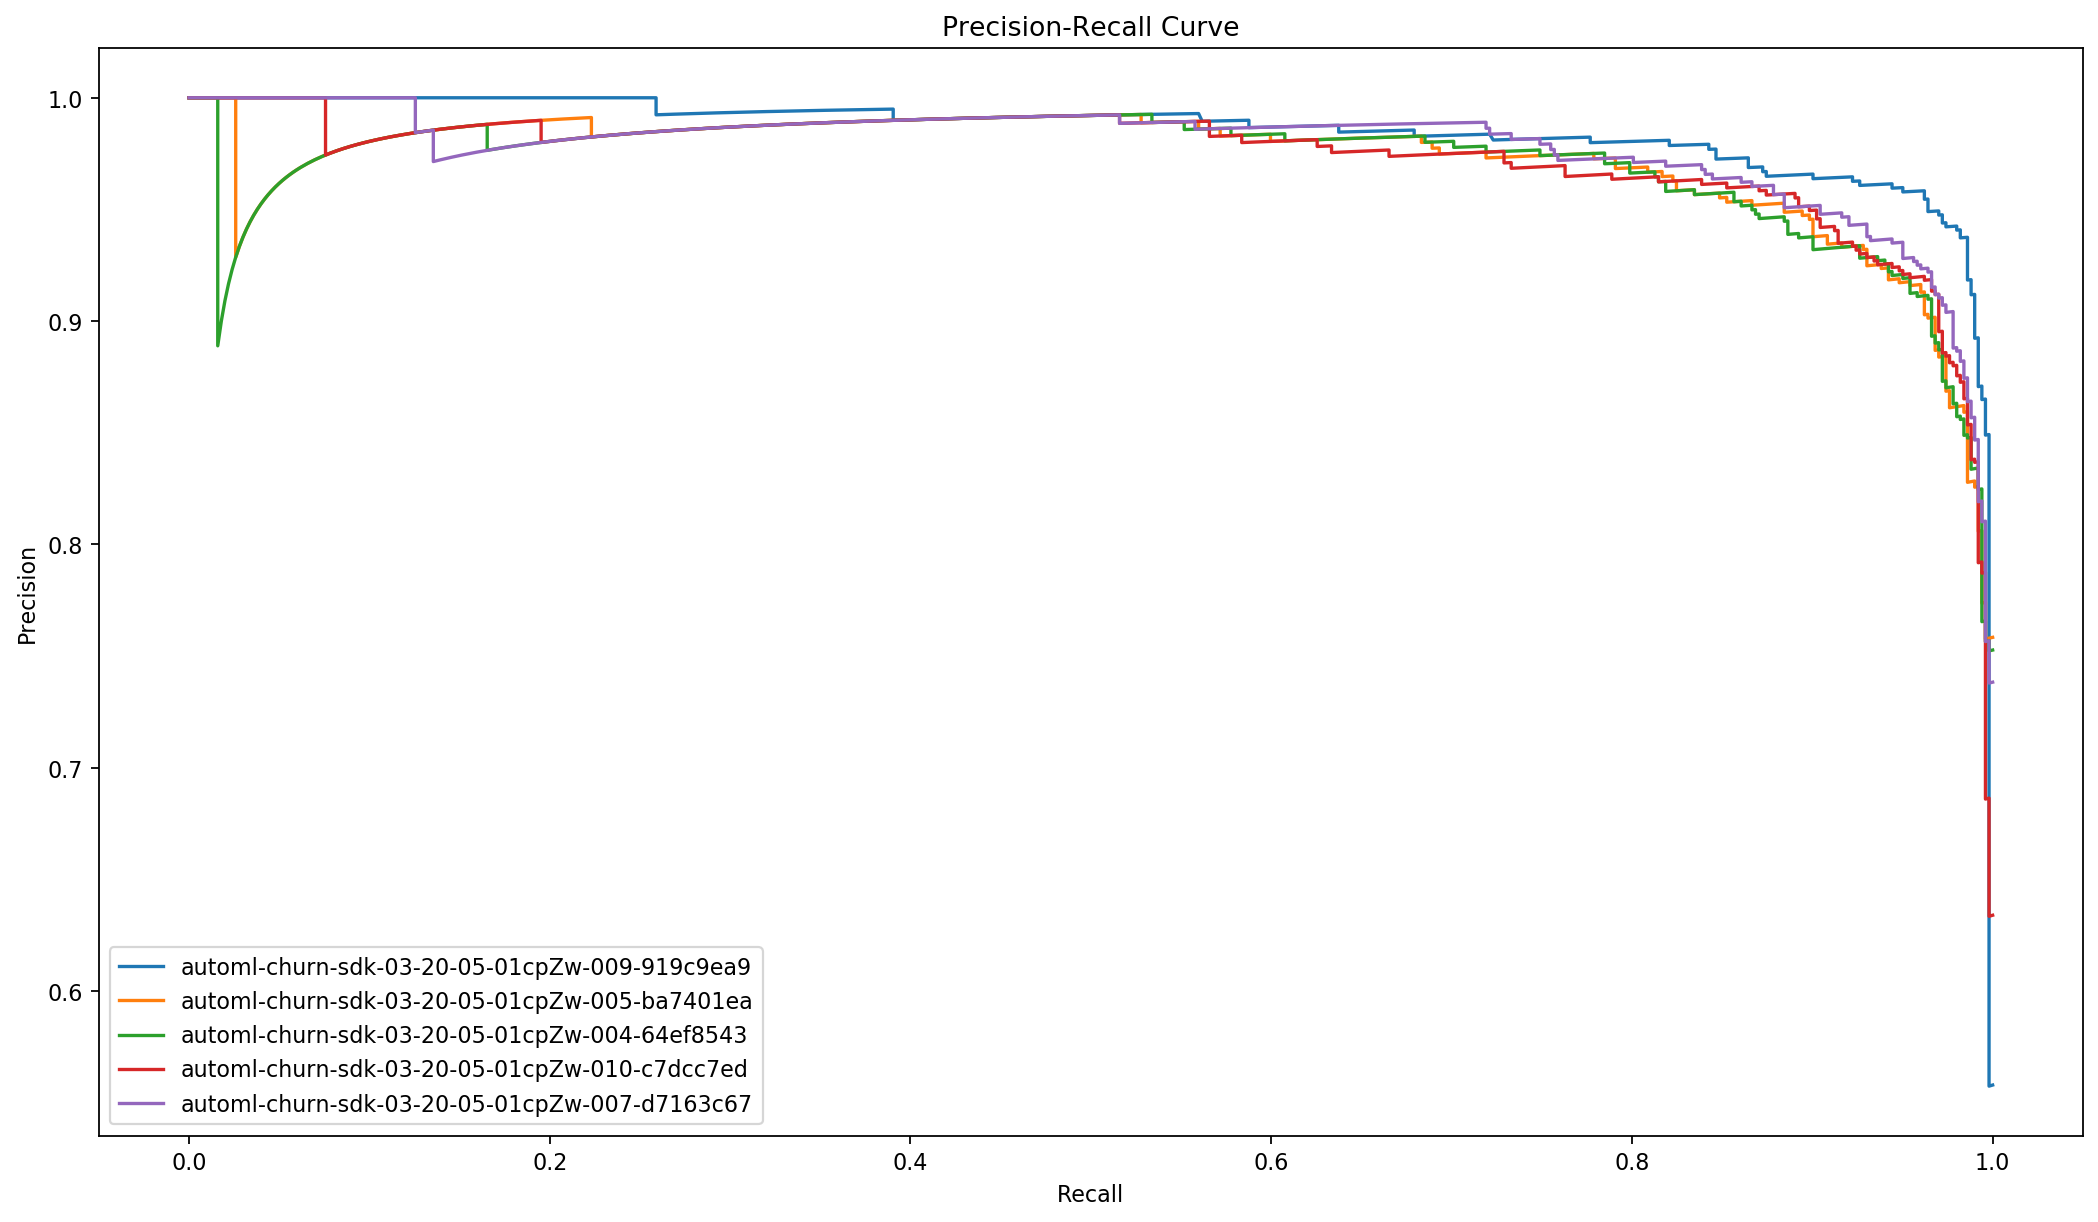

In [25]:
precision_recall = []
for prediction in predictions:
    precision, recall, _ = precision_recall_curve(labels, prediction.loc[:, 1])
    precision_recall.append(recall)
    precision_recall.append(precision)

plt.figure(num=None, figsize=(16, 9), dpi=160, facecolor="w", edgecolor="k")
plt.plot(*precision_recall)
plt.legend([candidate["CandidateName"] for candidate in candidates], loc="lower left")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

Given the target minimal precision, we will find the model that provides the best recall and the operation point for that model.

In [26]:
target_min_precision = 0.75

best_recall = 0
best_candidate_idx = -1
best_candidate_threshold = -1
candidate_idx = 0
for prediction in predictions:
    precision, recall, thresholds = precision_recall_curve(labels, prediction.loc[:, 1])
    threshold_idx = np.argmax(precision >= target_min_precision)
    if recall[threshold_idx] > best_recall:
        best_recall = recall[threshold_idx]
        best_candidate_threshold = thresholds[threshold_idx]
        best_candidate_idx = candidate_idx
    candidate_idx += 1

print("Best Candidate Name: {}".format(candidates[best_candidate_idx]["CandidateName"]))
print("Best Candidate Threshold (Operation Point): {}".format(best_candidate_threshold))
print("Best Candidate Recall: {}".format(best_recall))

Best Candidate Name: automl-churn-sdk-03-20-05-01cpZw-005-ba7401ea
Best Candidate Threshold (Operation Point): 0.0533392243087291
Best Candidate Recall: 1.0


Get predictions of the best model based on the selected operating point.

In [27]:
prediction_default = predictions[best_candidate_idx].loc[:, 0] == target_attribute_true_value
prediction_updated = predictions[best_candidate_idx].loc[:, 1] >= best_candidate_threshold

# compare the updated predictions to Autopilot's default
from sklearn.metrics import precision_score, recall_score

print(
    "Default Operating Point: recall={}, precision={}".format(
        recall_score(labels, prediction_default), precision_score(labels, prediction_default)
    )
)
print(
    "Updated Operating Point: recall={}, precision={}".format(
        recall_score(labels, prediction_updated), precision_score(labels, prediction_updated)
    )
)

Default Operating Point: recall=0.9482071713147411, precision=0.9171483622350675
Updated Operating Point: recall=1.0, precision=0.7583081570996979


### Deploy the Selected Candidate

After performing the analysis above, we can deploy the candidate that provides the best recall. We will use the `deploy` method to create the online inference endpoint. We'll use the same `inference_response_keys` from out batch transform jobs, but you can customize this as you wish. If `inference_response_keys` is not specified, only the `'predicted_label'` will be returned.


In [28]:
inference_response_keys

['predicted_label', 'probability']

In [29]:
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import CSVDeserializer

predictor = automl.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.2xlarge",
    candidate=candidates[best_candidate_idx],
    inference_response_keys=inference_response_keys,
    predictor_cls=Predictor,
    serializer=CSVSerializer(),
    deserializer=CSVDeserializer(),
)

print("Created endpoint: {}".format(predictor.endpoint_name))

----------------!Created endpoint: sagemaker-sklearn-automl-2021-09-03-21-59-18-998


Once we have created our endpoint, we can send real-time predictions to the endpoint. The inference output will contain the model's`predicted_label` and `probability`. We use the custom threshold calculated above to determine our own `custom_predicted_label` based on the probability score in the inference response. If a `probability` is less than the `best_candidate_threshold`, the `custom_predicted_label` is the `False.` class. If a `probability` is greater than of equal to the `best_candidate_threshold`, the `custom_predicted_label` is the `True.` class. 

In [30]:
best_candidate_threshold

0.0533392243087291

In [31]:
prediction = predictor.predict(test_data_no_target.to_csv(sep=",", header=False, index=False))
prediction_df = pd.DataFrame(prediction, columns=inference_response_keys)
custom_predicted_labels = prediction_df.iloc[:, 1].astype(float).values >= best_candidate_threshold
prediction_df["custom_predicted_label"] = custom_predicted_labels
prediction_df["custom_predicted_label"] = prediction_df["custom_predicted_label"].map(
    {False: target_attribute_values[0], True: target_attribute_values[1]}
)
prediction_df

,predicted_label,probability,custom_predicted_label
0,True.,0.6737548112869263,True.
1,True.,0.8799008131027222,True.
2,False.,0.29106569290161133,True.
3,False.,0.11236653476953506,True.
4,False.,0.007618059869855642,False.
...,...,...,...
995,True.,0.9322512745857239,True.
996,True.,0.9708477854728699,True.
997,False.,0.12182019650936127,True.
998,False.,0.11457133293151855,True.


---
## Cleanup <a name="Cleanup"></a>

The Autopilot job creates many underlying artifacts such as dataset splits, preprocessing scripts, or preprocessed data, etc. This code, when un-commented, deletes them. This operation deletes all the generated models and the auto-generated notebooks as well. 

In [32]:
# s3 = boto3.resource('s3')
# s3_bucket = s3.Bucket(bucket)

# s3_bucket.objects.filter(Prefix=prefix).delete()

Finally, we delete the models and the endpoint.

In [33]:
# for transformer in transformers:
#     transformer.delete_model()

# predictor.delete_endpoint()
# predictor.delete_model()